In [1]:
# Importing the packages
import pandas as pd
import numpy as np

# Importing visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

import statsmodels.formula.api as smf 
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score

In [2]:
cust = pd.read_csv("CUSTOMERS.csv")
geo = pd.read_csv("GEO_LOCATION.csv")
items = pd.read_csv("ORDER_ITEMS.csv")
payments = pd.read_csv("ORDER_PAYMENTS.csv")
ratings = pd.read_csv("ORDER_REVIEW_RATINGS.csv")
orders = pd.read_csv("ORDERS.csv")
products = pd.read_csv("PRODUCTS.csv")
sellers= pd.read_csv("SELLERS.csv")


In [3]:
# Merging customers and geo on customer_zip_code_prefix
merged_df = pd.merge(cust, geo, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='inner')

# Merging with orders on customer_id
merged_df = pd.merge(merged_df, orders, on='customer_id', how='inner')

# Merging with items on order_id
merged_df = pd.merge(merged_df, items, on='order_id', how='inner')

# Merging with payments on order_id
merged_df = pd.merge(merged_df, payments, on='order_id', how='inner')

# Merging with ratings on order_id
merged_df = pd.merge(merged_df, ratings, on='order_id', how='inner')

# Merging with products on product_id
merged_df = pd.merge(merged_df, products, on='product_id', how='inner')

# Merging with sellers on seller_id
merged_df = pd.merge(merged_df, sellers, on='seller_id', how='inner')


In [4]:
merged_df.dtypes

customer_id                       object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
geolocation_zip_code_prefix        int64
geolocation_lat                  float64
geolocation_lng                  float64
geolocation_city                  object
geolocation_state                 object
order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential                 int64
payment_type    

# 1. Perform Detailed exploratory analysis
a. Define & calculate high level metrics like (Total Revenue, Total quantity, Total
products, Total categories, Total sellers, Total locations, Total channels, Total
payment methods etc…)

In [5]:
# Total Revenue
total_revenue = merged_df['payment_value'].sum()

# Total Quantity
total_quantity = merged_df['order_item_id'].sum()

# Total Products
total_products = merged_df['product_id'].nunique()

# Total Categories
total_categories = merged_df['product_category_name'].nunique()

# Total Sellers
total_sellers = merged_df['seller_id'].nunique()

# Total Locations
total_locations = merged_df['customer_city'].nunique()

# Total Channels (Assuming channels are different order statuses)
total_channels = merged_df['order_status'].nunique()

# Total Payment Methods
total_payment_methods = merged_df['payment_type'].nunique()

# Display the calculated metrics
print("Total Revenue:", total_revenue)
print("Total Quantity:", total_quantity)
print("Total Products:", total_products)
print("Total Categories:", total_categories)
print("Total Sellers:", total_sellers)
print("Total Locations:", total_locations)
print("Total Channels:", total_channels)
print("Total Payment Methods:", total_payment_methods)

Total Revenue: 20360353.63
Total Quantity: 141201
Total Products: 32904
Total Categories: 71
Total Sellers: 3095
Total Locations: 4066
Total Channels: 7
Total Payment Methods: 4


# b. Understanding how many new customers acquired every month

In [6]:
# Convert 'order_purchase_timestamp' to datetime format
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])

# Extract month and year from 'order_purchase_timestamp'
merged_df['purchase_month'] = merged_df['order_purchase_timestamp'].dt.to_period('M')

# Count the number of unique customers acquired each month
new_customers_per_month = merged_df.groupby('purchase_month')['customer_id'].nunique()

# Display the result
print("Number of New Customers Acquired Each Month:")
print(new_customers_per_month)

Number of New Customers Acquired Each Month:
purchase_month
2016-09       2
2016-10     308
2016-12       1
2017-01     789
2017-02    1732
2017-03    2634
2017-04    2385
2017-05    3650
2017-06    3204
2017-07    3960
2017-08    4281
2017-09    4231
2017-10    4554
2017-11    7429
2017-12    5608
2018-01    7206
2018-02    6671
2018-03    7166
2018-04    6913
2018-05    6835
2018-06    6144
2018-07    6256
2018-08    6431
2018-09       1
Freq: M, Name: customer_id, dtype: int64


# c. Understand the retention of customers on month on month basis

In [7]:
# Calculate the monthly retention rate
monthly_retention = merged_df.groupby(['customer_id', 'purchase_month'])['order_id'].nunique().reset_index()
monthly_retention = monthly_retention.sort_values(by=['customer_id', 'purchase_month'])

# Create a column for the previous month
monthly_retention['previous_month'] = monthly_retention['purchase_month'].shift(1)

# Identify customers who made purchases in both the current and previous months
monthly_retention['retained_customer'] = (monthly_retention['purchase_month'] == monthly_retention['previous_month'])

# Calculate the retention rate for each month
retention_rate_per_month = monthly_retention.groupby('purchase_month')['retained_customer'].mean()

retention_rate_per_month

purchase_month
2016-09    0.000000
2016-10    0.000000
2016-12    0.000000
2017-01    0.006337
2017-02    0.016166
2017-03    0.027335
2017-04    0.021384
2017-05    0.046575
2017-06    0.032772
2017-07    0.041162
2017-08    0.050222
2017-09    0.035689
2017-10    0.045674
2017-11    0.074707
2017-12    0.056170
2018-01    0.070080
2018-02    0.065657
2018-03    0.074798
2018-04    0.074063
2018-05    0.067447
2018-06    0.064453
2018-07    0.061381
2018-08    0.062510
2018-09    0.000000
Freq: M, Name: retained_customer, dtype: float64

# d. How the revenues from existing/new customers on month on month basis

In [8]:
# Calculate monthly revenue for existing and new customers
monthly_revenue = merged_df.groupby(['purchase_month', 'customer_id'])['payment_value'].sum().reset_index()

# Categorize customers as existing or new based on their first purchase month
customer_first_purchase = merged_df.groupby('customer_id')['purchase_month'].min().reset_index()
customer_first_purchase.columns = ['customer_id', 'first_purchase_month']
monthly_revenue = pd.merge(monthly_revenue, customer_first_purchase, on='customer_id', how='inner')

# Categorize each transaction as from an existing or new customer
monthly_revenue['customer_type'] = np.where(monthly_revenue['purchase_month'] == monthly_revenue['first_purchase_month'], 'new', 'existing')

# Calculate total revenue for existing and new customers each month
revenue_per_customer_type = monthly_revenue.groupby(['purchase_month', 'customer_type'])['payment_value'].sum().unstack()

# Display the result
print("Monthly Revenue from Existing and New Customers:")
print(revenue_per_customer_type)

Monthly Revenue from Existing and New Customers:
customer_type          new
purchase_month            
2016-09             347.52
2016-10           74773.54
2016-12              19.62
2017-01          189570.02
2017-02          346214.31
2017-03          529089.48
2017-04          506293.47
2017-05          728384.99
2017-06          600675.37
2017-07          739321.80
2017-08          873339.48
2017-09         1019626.36
2017-10         1033583.68
2017-11         1585975.50
2017-12         1044183.97
2018-01         1416640.68
2018-02         1319077.08
2018-03         1479056.83
2018-04         1496448.86
2018-05         1503563.07
2018-06         1295888.99
2018-07         1351643.13
2018-08         1226469.42
2018-09             166.46


# e. Understand the trends/seasonality of sales, quantity by category, location, month, week, day, time, channel, payment method etc…

C:\Users\bless\AppData\Local\Temp\ipykernel_18004\1081709327.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  merged_df['purchase_week'] = merged_df['order_purchase_timestamp'].dt.week


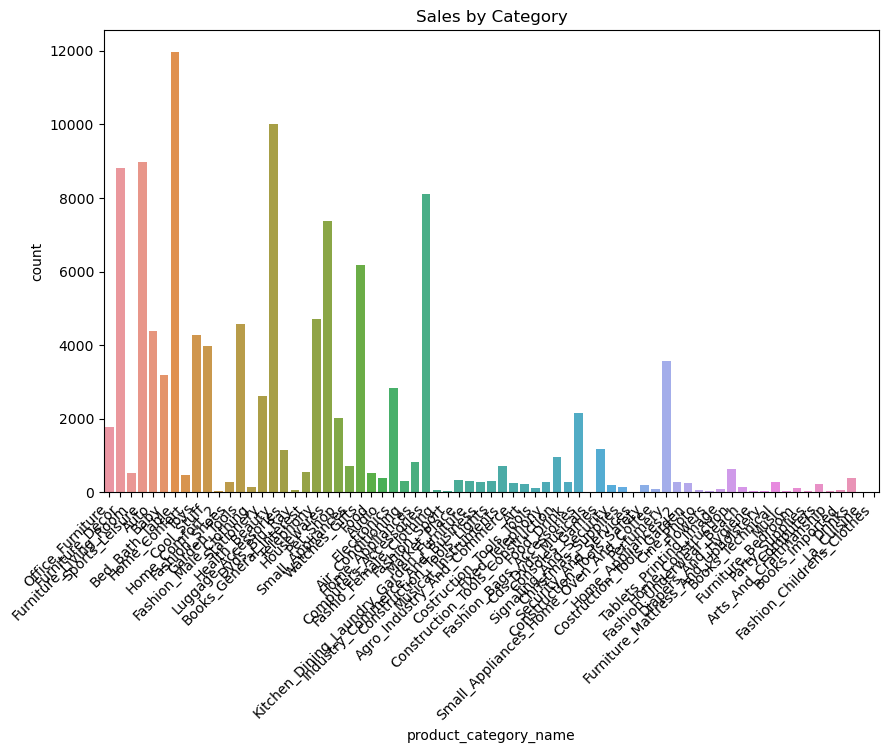

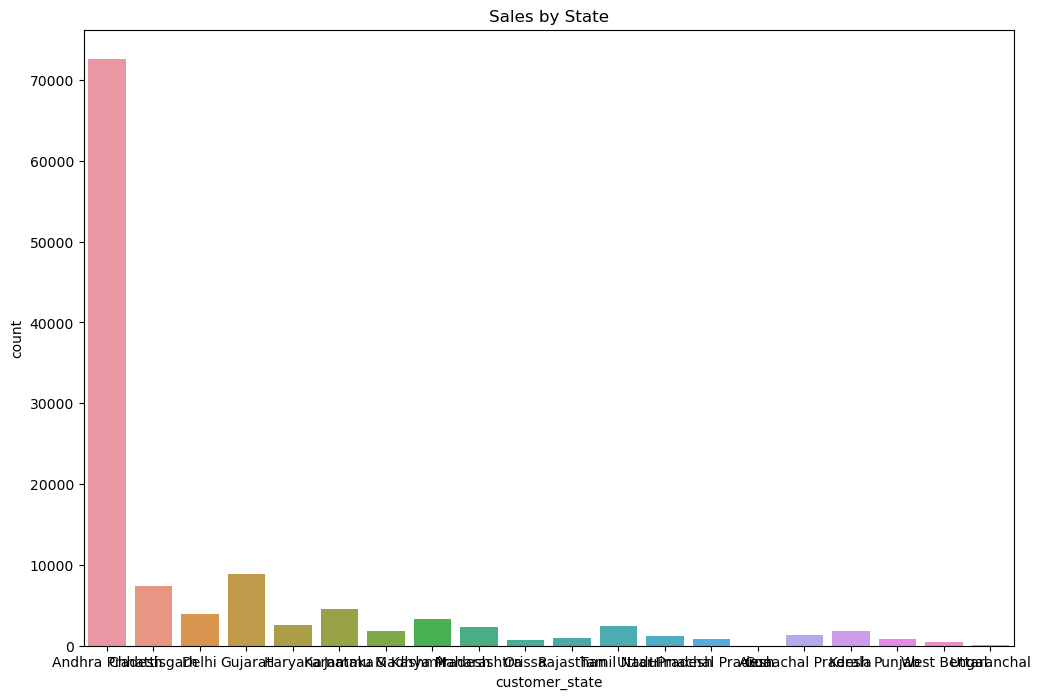

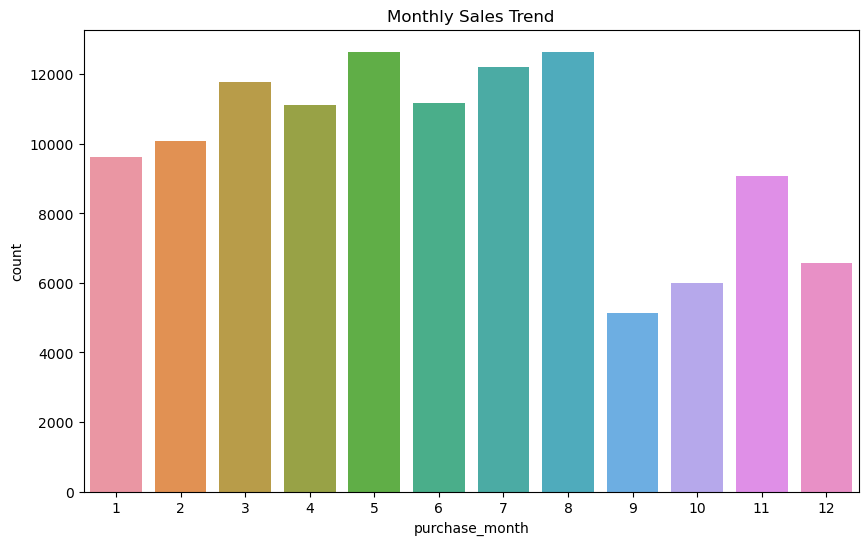

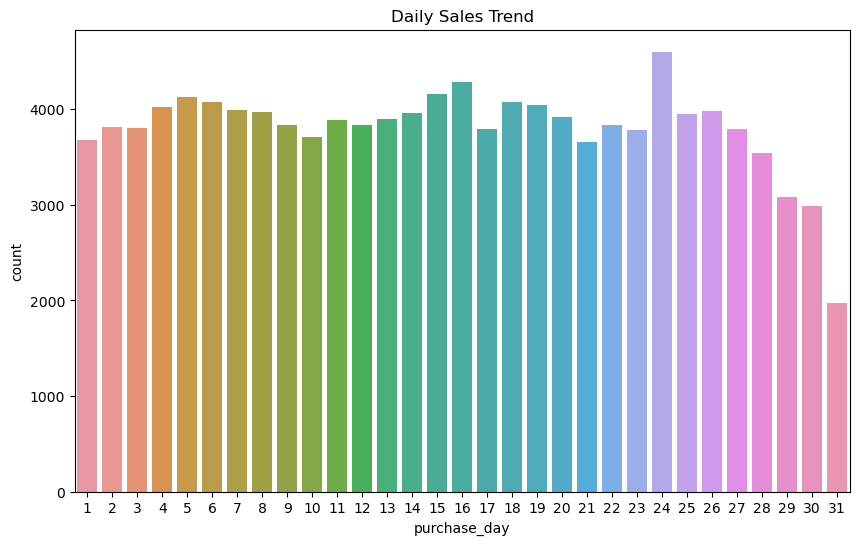

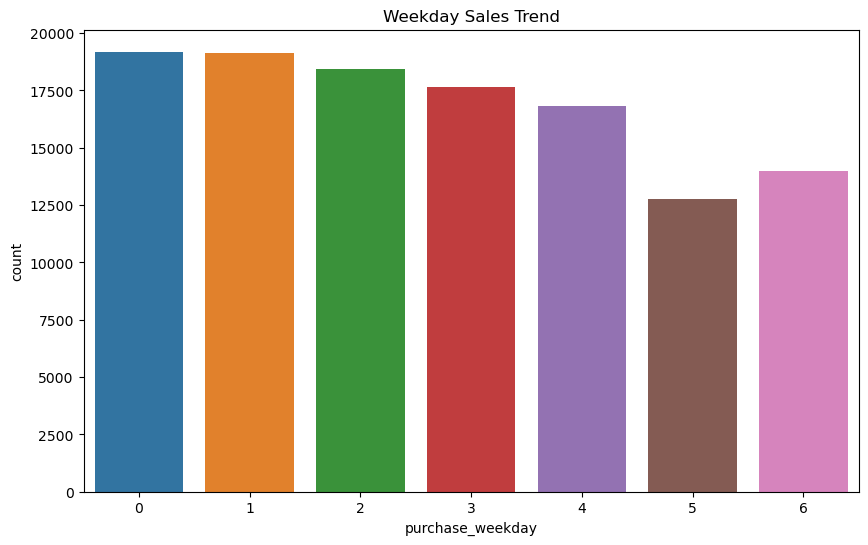

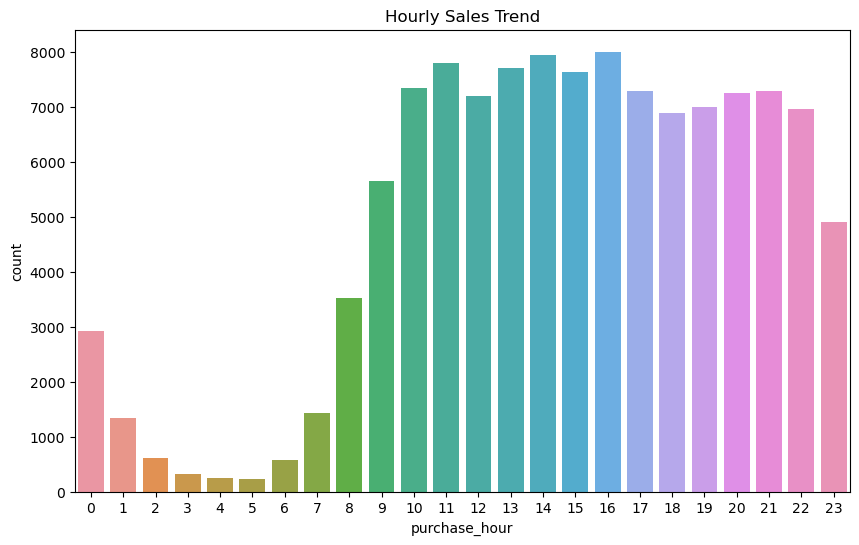

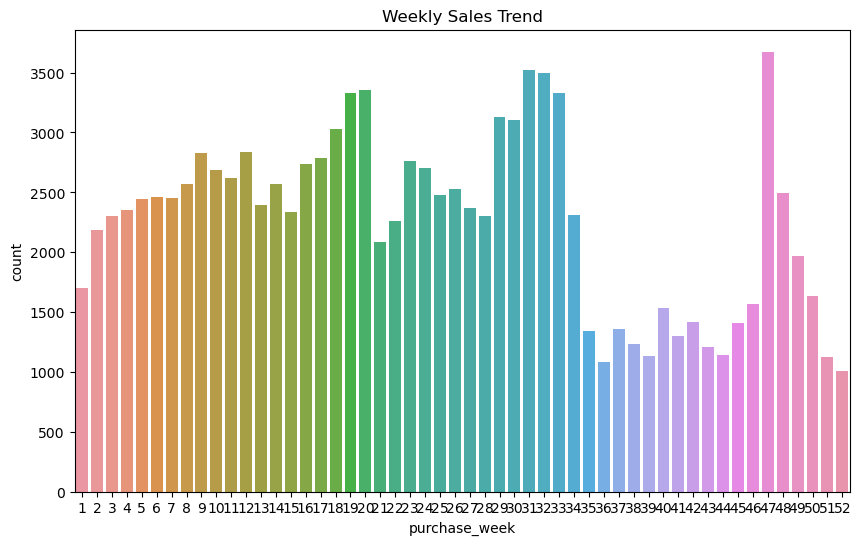

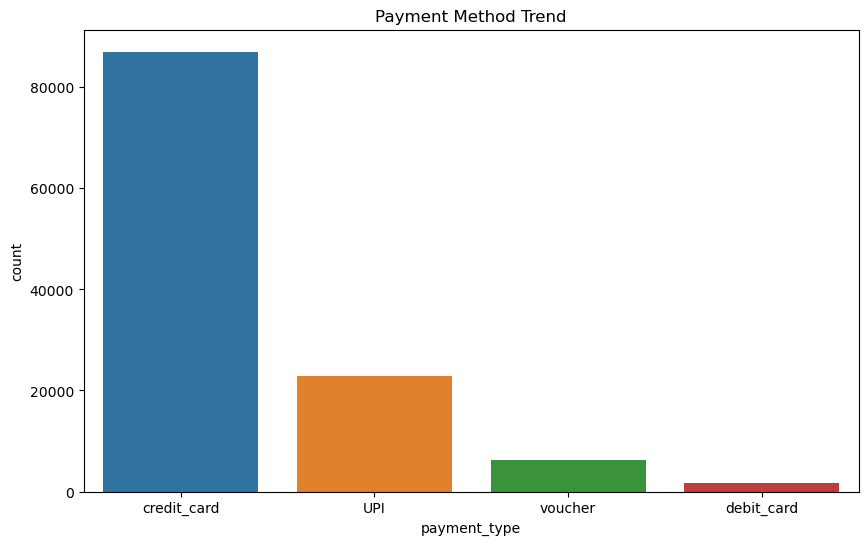

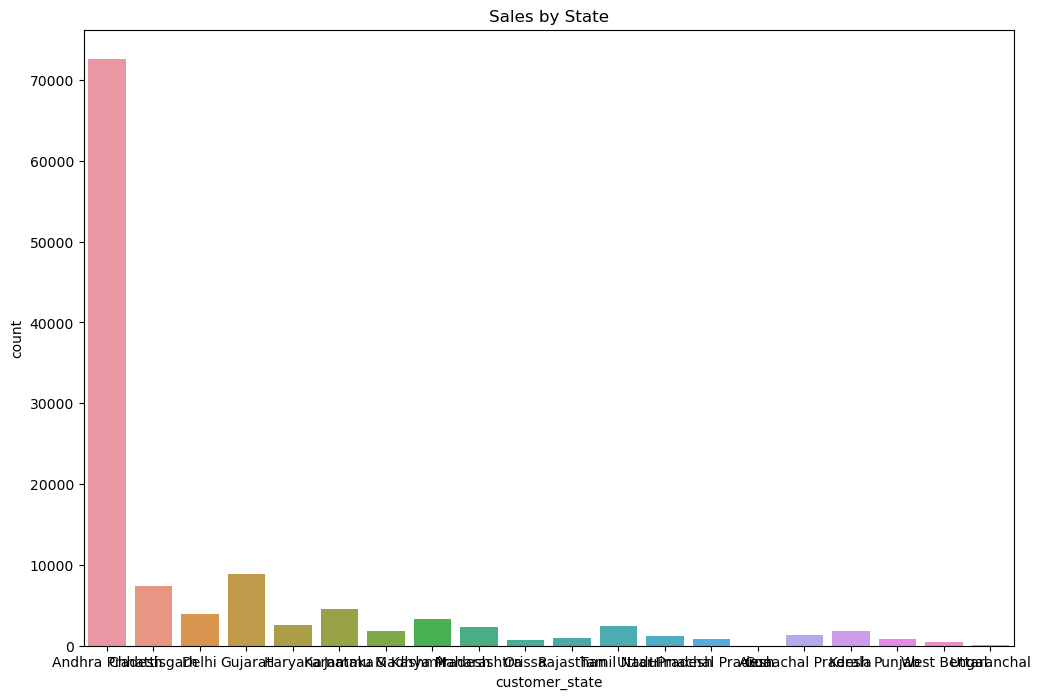

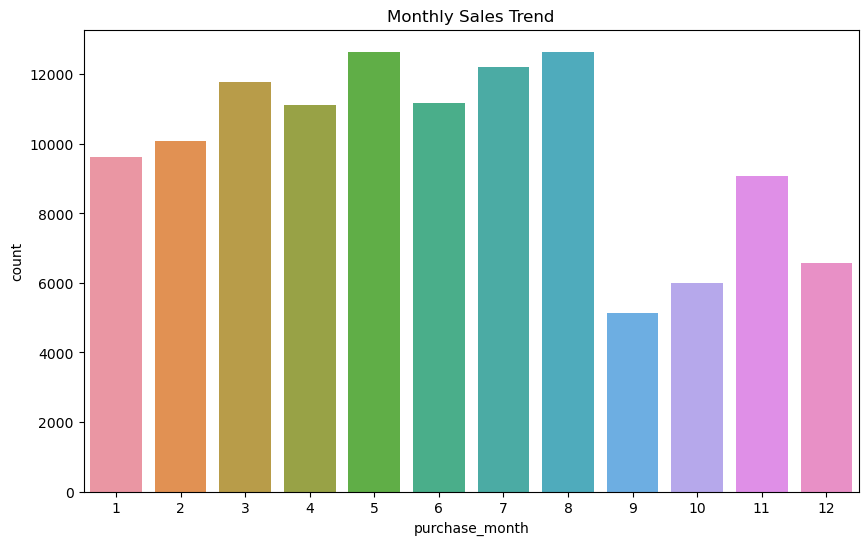

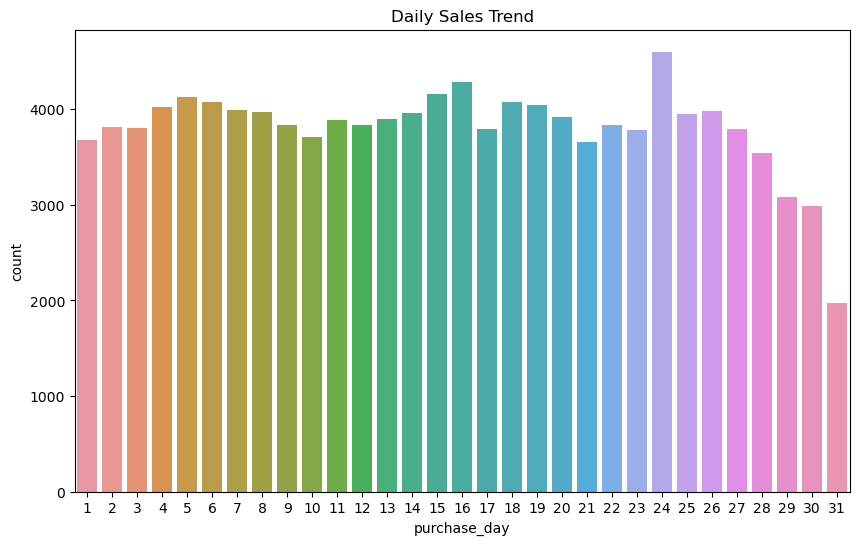

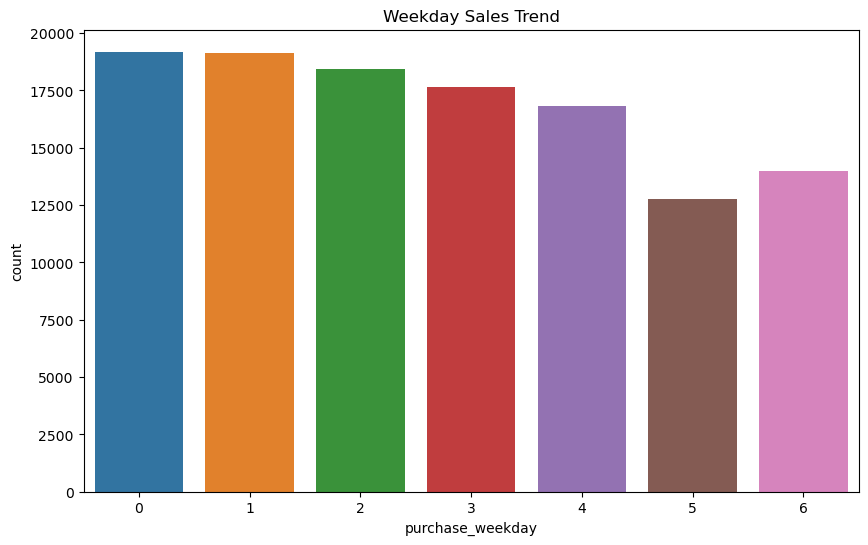

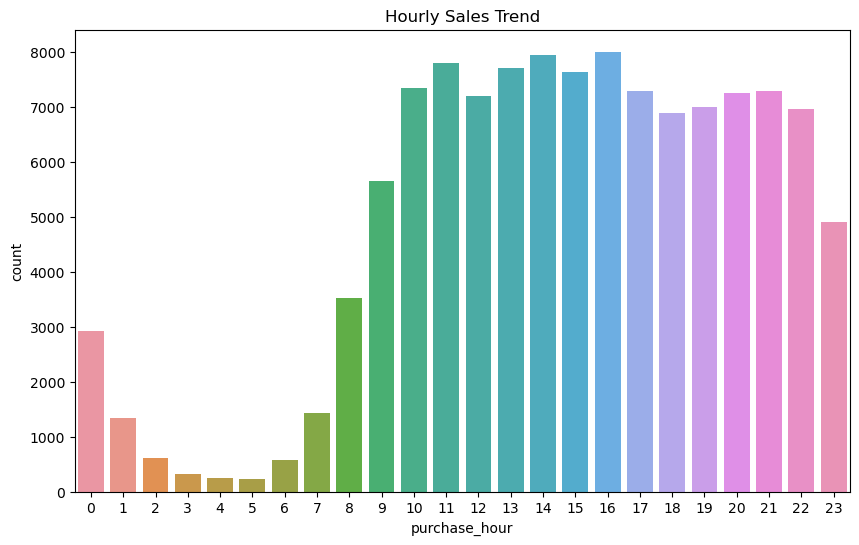

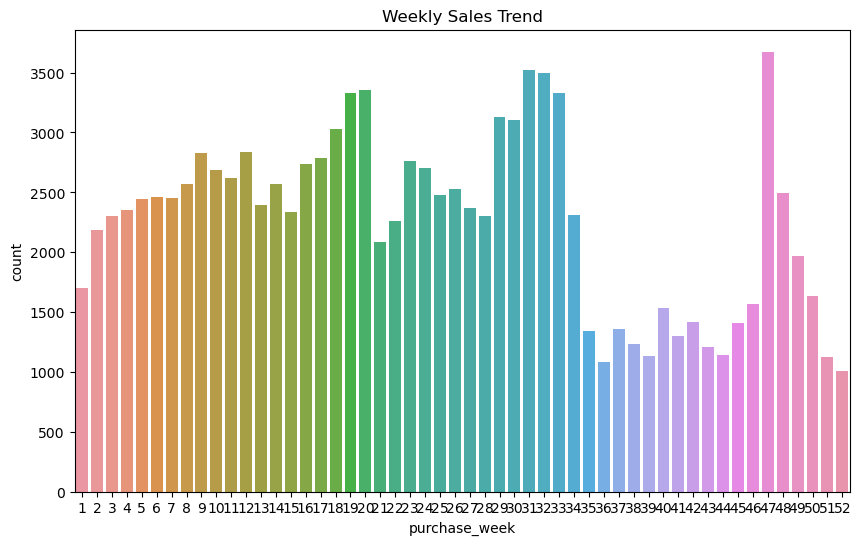

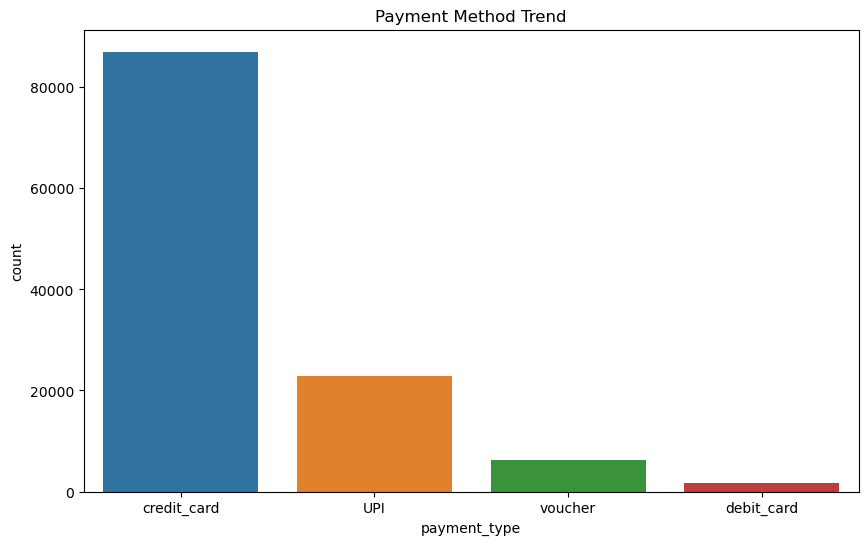

In [9]:
# Convert timestamp columns to datetime objects
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['order_delivered_customer_date'] = pd.to_datetime(merged_df['order_delivered_customer_date'])

# Extract features for analysis
merged_df['purchase_month'] = merged_df['order_purchase_timestamp'].dt.month
merged_df['purchase_day'] = merged_df['order_purchase_timestamp'].dt.day
merged_df['purchase_weekday'] = merged_df['order_purchase_timestamp'].dt.weekday
merged_df['purchase_hour'] = merged_df['order_purchase_timestamp'].dt.hour
merged_df['purchase_week'] = merged_df['order_purchase_timestamp'].dt.week

# Visualize trends by category
plt.figure(figsize=(10, 6))
sns.countplot(x='product_category_name', data=merged_df)
plt.xticks(rotation=45, ha='right')
plt.title('Sales by Category')
plt.show()
# Visualize trends by location
plt.figure(figsize=(12, 8))
sns.countplot(x='customer_state', data=merged_df)
plt.title('Sales by State')
plt.show()

# Visualize trends by month
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_month', data=merged_df)
plt.title('Monthly Sales Trend')
plt.show()

# Visualize trends by day
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_day', data=merged_df)
plt.title('Daily Sales Trend')
plt.show()

# Visualize trends by weekday
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_weekday', data=merged_df)
plt.title('Weekday Sales Trend')
plt.show()

# Visualize trends by hour
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_hour', data=merged_df)
plt.title('Hourly Sales Trend')
plt.show()

# Visualize trends by week
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_week', data=merged_df)
plt.title('Weekly Sales Trend')
plt.show()

# Visualize trends by payment method
plt.figure(figsize=(10, 6))
sns.countplot(x='payment_type', data=merged_df)
plt.title('Payment Method Trend')
plt.show()

# Visualize trends by location
plt.figure(figsize=(12, 8))
sns.countplot(x='customer_state', data=merged_df)
plt.title('Sales by State')
plt.show()

# Visualize trends by month
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_month', data=merged_df)
plt.title('Monthly Sales Trend')
plt.show()

# Visualize trends by day
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_day', data=merged_df)
plt.title('Daily Sales Trend')
plt.show()

# Visualize trends by weekday
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_weekday', data=merged_df)
plt.title('Weekday Sales Trend')
plt.show()

# Visualize trends by hour
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_hour', data=merged_df)
plt.title('Hourly Sales Trend')
plt.show()

# Visualize trends by week
plt.figure(figsize=(10, 6))
sns.countplot(x='purchase_week', data=merged_df)
plt.title('Weekly Sales Trend')
plt.show()

# Visualize trends by payment method
plt.figure(figsize=(10, 6))
sns.countplot(x='payment_type', data=merged_df)
plt.title('Payment Method Trend')
plt.show()

# f. Popular Products by month, seller, state, category.

In [34]:
# Popular Products by Month
popular_products_by_month = merged_df.groupby(['purchase_month', 'product_id'])['order_item_id'].sum().reset_index()
popular_products_by_month = popular_products_by_month.sort_values(by=['purchase_month', 'order_item_id'], ascending=[True, False])
popular_products_by_month = popular_products_by_month.drop_duplicates(subset='purchase_month')

# Popular Products by Seller
popular_products_by_seller = merged_df.groupby(['seller_id', 'product_id'])['order_item_id'].sum().reset_index()
popular_products_by_seller = popular_products_by_seller.sort_values(by='order_item_id', ascending=False)
popular_products_by_seller = popular_products_by_seller.drop_duplicates(subset='seller_id')

# Popular Products by State
popular_products_by_state = merged_df.groupby(['customer_state', 'product_id'])['order_item_id'].sum().reset_index()
popular_products_by_state = popular_products_by_state.sort_values(by='order_item_id', ascending=False)
popular_products_by_state = popular_products_by_state.drop_duplicates(subset='customer_state')

# Popular Products by Category
popular_products_by_category = merged_df.groupby(['product_category_name', 'product_id'])['order_item_id'].sum().reset_index()
popular_products_by_category = popular_products_by_category.sort_values(by='order_item_id', ascending=False)
popular_products_by_category = popular_products_by_category.drop_duplicates(subset='product_category_name')

# Display the results
print("Popular Products by Month:")
print(popular_products_by_month[['purchase_month', 'product_id']])

print("\nPopular Products by Seller:")
print(popular_products_by_seller[['seller_id', 'product_id']])

print("\nPopular Products by State:")
print(popular_products_by_state[['customer_state', 'product_id']])

print("\nPopular Products by Category:")
print(popular_products_by_category[['product_category_name', 'product_id']])

Popular Products by Month:
      purchase_month                        product_id
1            2016-09  f293394c72c9b5fafd7023301fc21fc2
234          2016-10  d9894482fba41f536a273ba2276d951f
277          2016-12  f5d8f4fbc70ca2a0038b9a0010ed5cb0
412          2017-01  37eb69aca8718e843d897aa7b82f462d
1327         2017-02  58efb9b638561ce132216a9a612513e2
3009         2017-03  7e0dc102074f8285580c9777f79c90cf
4895         2017-04  99a4788cb24856965c36a24e339b6058
7001         2017-05  99a4788cb24856965c36a24e339b6058
8474         2017-06  42a2c92a0979a949ca4ea89ec5c7b934
10383        2017-07  270516a3f41dc035aa87d220228f844c
14151        2017-08  9571759451b1d780ee7c15012ea109d4
15422        2017-09  0554911df28fda9fd668ce5ba5949695
18217        2017-10  03e1c946c0ddfc58724ff262aef08dff
22110        2017-11  389d119b48cf3043d311335e499d9c6b
26539        2017-12  422879e10f46682990de24d770e7f83d
31780        2018-01  aca2eb7d00ea1a7b8ebd4e68314663af
36685        2018-02  ee3d532c8a438679

# g. Popular categories by state, month

In [36]:
# Popular Categories by State
popular_categories_by_state = merged_df.groupby(['customer_state', 'product_category_name'])['order_item_id'].sum().reset_index()
popular_categories_by_state = popular_categories_by_state.sort_values(by=['customer_state', 'order_item_id'], ascending=[True, False])
popular_categories_by_state = popular_categories_by_state.drop_duplicates(subset='customer_state')

# Popular Categories by Month
popular_categories_by_month = merged_df.groupby(['purchase_month', 'product_category_name'])['order_item_id'].sum().reset_index()
popular_categories_by_month = popular_categories_by_month.sort_values(by=['purchase_month', 'order_item_id'], ascending=[True, False])
popular_categories_by_month = popular_categories_by_month.drop_duplicates(subset='purchase_month')

# Display the results
print("Popular Categories by State:")
print(popular_categories_by_state[['customer_state', 'product_category_name']])

print("\nPopular Categories by Month:")
print(popular_categories_by_month[['purchase_month', 'product_category_name']])

Popular Categories by State:
         customer_state product_category_name
7        Andhra Pradesh        Bed_Bath_Table
101   Arunachal Pradesh       Furniture_Decor
132        Chhattisgarh        Bed_Bath_Table
226               Delhi       Furniture_Decor
255                 Goa                  Auto
271             Gujarat        Bed_Bath_Table
338             Haryana        Bed_Bath_Table
395    Himachal Pradesh        Bed_Bath_Table
472     Jammu & Kashmir       Furniture_Decor
504           Karnataka        Bed_Bath_Table
567              Kerala        Bed_Bath_Table
624      Madhya Pradesh        Bed_Bath_Table
690         Maharashtra        Bed_Bath_Table
749              Orissa        Bed_Bath_Table
824              Punjab         Health_Beauty
889           Rajasthan        Sports_Leisure
900          Tamil Nadu        Bed_Bath_Table
959       Uttar Pradesh        Bed_Bath_Table
1013        Uttaranchal            Cool_Stuff
1036        West Bengal                  Baby

Popu

# h. List top 10 most expensive products sorted by price

In [37]:
# List Top 10 Most Expensive Products
top_expensive_products = merged_df[['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'price']].sort_values(by='price', ascending=False).head(10)

# Display the result
print("Top 10 Most Expensive Products:")
print(top_expensive_products)

Top 10 Most Expensive Products:
                              product_id product_category_name  \
115921  489ae2aa008f021502940f251d4cce7f            Housewares   
117766  69c590f7ffc7bf8db97190b6cb6ed62e             Computers   
116964  1bdf5e6731585cf01aa8169c7028d6ad                   Art   
111037  a6492cc69376c469ab6f61d8f44de961      Small_Appliances   
111044  c3ed642d592594bb648ff4a04cee2747      Small_Appliances   
93890   259037a6a41845e455183f89c5035f18             Computers   
111645  a1beef8f3992dbd4cd8726796aa69c53   Musical_Instruments   
69498   6cdf8fc1d741c76586d8b6b15e9eef30        Consoles_Games   
79664   dd113cb02b2af9c8e5787e8f1f0722f6        Sports_Leisure   
10863   6902c1962dd19d540807d0ab8fade5c6         Watches_Gifts   

        product_name_lenght  product_description_lenght    price  
115921                 31.0                       875.0  6735.00  
117766                 50.0                      1935.0  6729.00  
116964                 28.0             

# 2. Performing Customers/sellers Segmentation
a. Divide the customers into groups based on the revenue generated 

In [38]:
# Calculate total revenue per customer
customer_revenue = merged_df.groupby('customer_id')['payment_value'].sum().reset_index()

# Define quantiles for segmentation
quantiles = [0, 0.25, 0.5, 0.75, 1.0]

# Segment customers based on revenue quantiles
customer_revenue['revenue_segment'] = pd.qcut(customer_revenue['payment_value'], quantiles, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Display the result
print("Customer Segmentation Based on Revenue:")
print(customer_revenue[['customer_id', 'payment_value', 'revenue_segment']])

Customer Segmentation Based on Revenue:
                            customer_id  payment_value revenue_segment
0      00012a2ce6f8dcda20d059ce98491703         114.74     Medium-High
1      000161a058600d5901f007fab4c27140          67.41      Medium-Low
2      0001fd6190edaaf884bcaf3d49edf079         195.42     Medium-High
3      0002414f95344307404f0ace7a26f1d5         179.35     Medium-High
4      000379cdec625522490c315e70c7a9fb         107.01      Medium-Low
...                                 ...            ...             ...
98386  fffcb937e9dd47a13f05ecb8290f4d3e          91.91      Medium-Low
98387  fffecc9f79fd8c764f843e9951b11341          81.36      Medium-Low
98388  fffeda5b6d849fbd39689bb92087f431          63.13      Medium-Low
98389  ffff42319e9b2d713724ae527742af25         214.13            High
98390  ffffa3172527f765de70084a7e53aae8          91.00      Medium-Low

[98391 rows x 3 columns]


# b. Divide the sellers into groups based on the revenue generated 

In [39]:
# Calculate total revenue per seller
seller_revenue = merged_df.groupby('seller_id')['payment_value'].sum().reset_index()

# Define quantiles for segmentation
quantiles = [0, 0.25, 0.5, 0.75, 1.0]

# Segment sellers based on revenue quantiles
seller_revenue['revenue_segment'] = pd.qcut(seller_revenue['payment_value'], quantiles, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Display the result
print("Seller Segmentation Based on Revenue:")
print(seller_revenue[['seller_id', 'payment_value', 'revenue_segment']])

Seller Segmentation Based on Revenue:
                             seller_id  payment_value revenue_segment
0     0015a82c2db000af6aaaf3ae2ecb0532        2748.06     Medium-High
1     001cca7ae9ae17fb1caed9dfb1094831       48349.22            High
2     001e6ad469a905060d959994f1b41e4f         267.94             Low
3     002100f778ceb8431b7a1020ff7ab48f        2478.33     Medium-High
4     003554e2dce176b5555353e4f3555ac8         139.38             Low
...                                ...            ...             ...
3090  ffcfefa19b08742c5d315f2791395ee5          79.52             Low
3091  ffdd9f82b9a447f6f8d4b91554cc7dd3        3607.52     Medium-High
3092  ffeee66ac5d5a62fe688b9d26f83f534        2259.55     Medium-High
3093  fffd5413c0700ac820c7069d66d98c89       12834.27            High
3094  ffff564a4f9085cd26170f4732393726        1770.86     Medium-High

[3095 rows x 3 columns]


# 3. Cross-Selling (Which products are selling together)

In [40]:
from itertools import combinations

transactions = merged_df.groupby('order_id')['product_id'].unique()

# Create a list to store product combinations
product_combinations = []

# Iterate through each transaction
for products in transactions:
    # Generate combinations of 2 and 3 products
    combinations_2 = list(combinations(products, 2))
    combinations_3 = list(combinations(products, 3))
    
    # Add combinations to the list
    product_combinations.extend(combinations_2)
    product_combinations.extend(combinations_3)

# Count the occurrences of each combination
combination_counts = pd.Series(product_combinations).value_counts()

# Display the top 10 combinations
top_10_combinations = combination_counts.head(10)
print("Top 10 Product Combinations:")
print(top_10_combinations)

Top 10 Product Combinations:
(36f60d45225e60c7da4558b070ce4b60, e53e557d5a159f5aa2c5e995dfdf244b)    32
(99a4788cb24856965c36a24e339b6058, 35afc973633aaeb6b877ff57b2793310)    29
(f4f67ccaece962d013a4e1d7dc3a61f7, 4fcb3d9a5f4871e8362dfedbdb02b064)    17
(389d119b48cf3043d311335e499d9c6b, 422879e10f46682990de24d770e7f83d)    11
(36f60d45225e60c7da4558b070ce4b60, 3f14d740544f37ece8a9e7bc8349797e)    10
(389d119b48cf3043d311335e499d9c6b, 53759a2ecddad2bb87a079a1f1519f73)     9
(368c6c730842d78016ad823897a372db, 53759a2ecddad2bb87a079a1f1519f73)     8
(422879e10f46682990de24d770e7f83d, 53759a2ecddad2bb87a079a1f1519f73)     7
(98d61056e0568ba048e5d78038790e77, 060cb19345d90064d1015407193c233d)     6
(ad0a798e7941f3a5a2fb8139cb62ad78, 946344697156947d846d27fe0d503033)     6
dtype: int64


# 4. Payment Behaviour                                                                                             a. How customers are paying?


In [41]:
# Count the occurrences of each payment method
payment_distribution = merged_df['payment_type'].value_counts()

# Display the payment distribution
print("Payment Distribution:")
print(payment_distribution)

Payment Distribution:
credit_card    87026
UPI            22957
voucher         6317
debit_card      1698
Name: payment_type, dtype: int64


# b. Which payment channels are used by most customers?

In [42]:
# Count the occurrences of each payment method
payment_channel_distribution = merged_df['payment_type'].value_counts()

# Display the payment channel distribution
print("Payment Channel Distribution:")
print(payment_channel_distribution)

Payment Channel Distribution:
credit_card    87026
UPI            22957
voucher         6317
debit_card      1698
Name: payment_type, dtype: int64


# 5. Customer satisfaction towards category & product
a. Which categories (top 10) are maximum rated & minimum rated?

In [43]:
category_ratings = merged_df.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False)

# Display the top 10 maximum-rated categories
print("Top 10 Maximum-Rated Categories:")
print(category_ratings.head(10))

# Display the top 10 minimum-rated categories
print("\nTop 10 Minimum-Rated Categories:")
print(category_ratings.tail(10))

Top 10 Maximum-Rated Categories:
product_category_name
Cds_Dvds_Musicals                        4.642857
Fashion_Childrens_Clothes                4.500000
Books_General_Interest                   4.430851
Books_Imported                           4.419355
Books_Technical                          4.345588
Costruction_Tools_Tools                  4.333333
Small_Appliances_Home_Oven_And_Coffee    4.320513
Food_Drink                               4.312715
Luggage_Accessories                      4.289905
Cine_Photo                               4.216216
Name: review_score, dtype: float64

Top 10 Minimum-Rated Categories:
product_category_name
Construction_Tools_Safety            3.834171
Audio                                3.823684
Furniture_Mattress_And_Upholstery    3.804878
Fashio_Female_Clothing               3.780000
Fixed_Telephony                      3.660517
Fashion_Male_Clothing                3.531034
Office_Furniture                     3.516274
Home_Comfort_2                  

# b. Which products (top10) are maximum rated & minimum rated?

In [44]:
product_ratings = merged_df.groupby('product_id')['review_score'].mean().sort_values(ascending=False)

# Display the top 10 maximum-rated products
print("Top 10 Maximum-Rated Products:")
print(product_ratings.head(10))

# Display the top 10 minimum-rated products
print("\nTop 10 Minimum-Rated Products:")
print(product_ratings.tail(10))

Top 10 Maximum-Rated Products:
product_id
00066f42aeeb9f3007548bb9d3f33c38    5.0
865bfa00c1dad8f4146d3c2765f051ca    5.0
868969d3a93aeeab7bfcd4fc3d3d65de    5.0
868766ed2172644fdd977d6bd395a107    5.0
8684bd8f93b4f4038d07188a23811e93    5.0
867c96d2bb67aba6500a4c509cf76072    5.0
867b820367ec206b38a357f2c12454b7    5.0
867901d7e8488fb97f1fb538c09d476e    5.0
86743ff92eee3d16b7df59cddd583b8c    5.0
8657986fc307b1b749c57763b90795f8    5.0
Name: review_score, dtype: float64

Top 10 Minimum-Rated Products:
product_id
560aa6044750b7511a18e5ee9aaffa17    1.0
c3cdb28ed53f4ec5d9afe32753961641    1.0
ee8138bcca833152a19543702228ee26    1.0
19290ebcf78e385cd9fcd48ce5e1393d    1.0
c3c075d20bbf03a458eb5c4458d82380    1.0
1938ab47ef011dae9e4ced458166432e    1.0
c39610045a59ffcd596a9e9ce4341921    1.0
703655144396d09091d9280259c9e51b    1.0
703be08855ce485a358cc217d93a05d4    1.0
c7796bc610cc40ed7935b75fced0aa0e    1.0
Name: review_score, dtype: float64


# c. Average rating by location, seller, product, category, month etc.

In [46]:
# Calculate average rating by location
average_rating_by_location = merged_df.groupby('customer_state')['review_score'].mean()

# Calculate average rating by seller
average_rating_by_seller = merged_df.groupby('seller_id')['review_score'].mean()

# Calculate average rating by product
average_rating_by_product = merged_df.groupby('product_id')['review_score'].mean()

# Calculate average rating by category
average_rating_by_category = merged_df.groupby('product_category_name')['review_score'].mean()

# Calculate average rating by month
average_rating_by_month = merged_df.groupby(merged_df['order_purchase_timestamp'].dt.to_period("M"))['review_score'].mean()

# Display the results
print("Average Rating by Location:")
print(average_rating_by_location)

print("\nAverage Rating by Seller:")
print(average_rating_by_seller)

print("\nAverage Rating by Product:")
print(average_rating_by_product)

print("\nAverage Rating by Category:")
print(average_rating_by_category)

print("\nAverage Rating by Month:")
print(average_rating_by_month)

Average Rating by Location:
customer_state
Andhra Pradesh       3.995468
Arunachal Pradesh    4.023503
Chhattisgarh         4.031136
Delhi                4.028025
Goa                  4.777778
Gujarat              4.038444
Haryana              4.119375
Himachal Pradesh     3.989535
Jammu & Kashmir      3.998359
Karnataka            4.015584
Kerala               4.051181
Madhya Pradesh       3.996139
Maharashtra          4.091890
Orissa               4.084770
Punjab               4.163636
Rajasthan            4.098592
Tamil Nadu           4.111202
Uttar Pradesh        4.129614
Uttaranchal          3.669811
West Bengal          3.985714
Name: review_score, dtype: float64

Average Rating by Seller:
seller_id
0015a82c2db000af6aaaf3ae2ecb0532    3.666667
001cca7ae9ae17fb1caed9dfb1094831    3.883817
001e6ad469a905060d959994f1b41e4f    1.000000
002100f778ceb8431b7a1020ff7ab48f    4.033898
003554e2dce176b5555353e4f3555ac8    5.000000
                                      ...   
ffcfefa19b08742

In [35]:
# Display the head of the merged DataFrame
merged_df.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'geolocation_zip_code_prefix',
       'geolocation_lat', 'geolocation_lng', 'geolocation_city',
       'geolocation_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_id', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix',
       'seller_city', 'seller_state', 'purchase_month', '